In [16]:
import os

os.environ["PYTHONHASHSEED"] = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0"

import sys

sys.path.insert(0, "../")

import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf

rn.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math
import matplotlib.pyplot as plt


In [17]:
def get_abs_path(currentfile, filepath):
    dirname = os.path.dirname(currentfile)
    return os.path.join(dirname, filepath)

In [18]:

cols_list = [
    "startEpochTime",
    "openPrice",
    "highPrice",
    "lowPrice",
    "volume",
    "closePrice",
]

stock_history = pd.read_csv("../data/TSLA.csv")
stock_history = stock_history[cols_list]

scaler = MinMaxScaler()
stock_history = scaler.fit_transform(stock_history)
stock_history = pd.DataFrame(stock_history)
stock_history = stock_history.tail(5000)


In [19]:
TRAINING_LENGTH = math.ceil(0.90 * len(stock_history))
training_data = stock_history.iloc[:TRAINING_LENGTH, :]

x_train, y_train = [], []
BATCH_SIZE = 30
NO_OF_INPUT_COLS = 5

for i in range(BATCH_SIZE, len(training_data) - 2):
    x_train.append(
        training_data.iloc[i - BATCH_SIZE : i, 0:NO_OF_INPUT_COLS].to_numpy().tolist()
    )
    y_train.append(
        training_data.iloc[i : i + 1, NO_OF_INPUT_COLS : NO_OF_INPUT_COLS + 1]
        .iloc[0, :]
        .to_numpy()
        .tolist()
    )

x_train, y_train = np.array(x_train), np.array(y_train)


In [20]:
regressor = Sequential()
regressor.add(
    LSTM(
        units=100,
        activation="relu",
        return_sequences=True,
        input_shape=(x_train.shape[1], x_train.shape[2]),
    )
)
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, activation="relu", return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, activation="relu", return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=100, activation="relu"))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(
    optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"]
)


In [21]:
stoppingCallback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

regressor.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    callbacks=[stoppingCallback],
    shuffle=False,
)


Epoch 1/100
149/149 [==============================] - 9s 60ms/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 2/100
149/149 [==============================] - 9s 62ms/step - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 3/100
149/149 [==============================] - 10s 68ms/step - loss: 0.0154 - mean_squared_error: 0.0154
Epoch 4/100
149/149 [==============================] - 11s 71ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 5/100
149/149 [==============================] - 10s 68ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 6/100
149/149 [==============================] - 10s 66ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 7/100
149/149 [==============================] - 10s 64ms/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 8/100
149/149 [==============================] - 10s 65ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 9/100
149/149 [==============================] - 10s 66ms/step - loss: 0.0256 - mean_squared

In [22]:
test_data = stock_history.iloc[TRAINING_LENGTH:, :]

x_test, y_test = [], []

for i in range(BATCH_SIZE, len(test_data)):
    x_test.append(
        test_data.iloc[i - BATCH_SIZE : i, 0:NO_OF_INPUT_COLS].to_numpy().tolist()
    )
    y_test.append(
        test_data.iloc[i : i + 1, NO_OF_INPUT_COLS : NO_OF_INPUT_COLS + 1]
        .iloc[0, :]
        .to_numpy()
        .tolist()
    )

x_test = np.array(x_test)
y_test = np.array(y_test)


In [23]:

test_score, test_acc = regressor.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(test_score, test_acc)

y_predict = regressor.predict(x_test)

# x_test = x_test / scaler.scale_[0] + scaler.data_min_[0]
y_predict = (
    y_predict / scaler.scale_[NO_OF_INPUT_COLS] + scaler.data_min_[NO_OF_INPUT_COLS]
)
y_test = y_test / scaler.scale_[NO_OF_INPUT_COLS] + scaler.data_min_[NO_OF_INPUT_COLS]



16/16 [==============================] - 0s 15ms/step - loss: 0.0087 - mean_squared_error: 0.0087
0.008707970380783081 0.008707970380783081


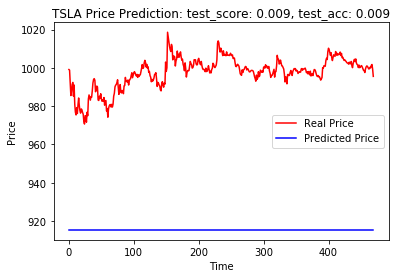

In [25]:
plt.close()
fig = plt.gcf()
plt.plot(y_test, color="red", label="Real Price")
plt.plot(y_predict, color="blue", label="Predicted Price")
title = "TSLA Price Prediction: test_score: {test_score:.3f}, test_acc: {test_acc:.3f}".format(
    test_score=test_score, test_acc=test_acc
)

plt.title(title)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
fig.savefig("../charts/tsla-prediction.png", dpi=fig.dpi)
plt.show()
